In [3]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
from bsuite.environments import cartpole

from mbrlax.models import GPModelSpec, SVGP, initialize_gp_model
from mbrlax.utils import ReplayBuffer, Driver, EnvironmentModel
from mbrlax.policy import GPPolicy
from mbrlax.transition_model import GPTransitionModel
from mbrlax.optimizers import SGD

from gpjax.likelihoods import Gaussian
from gpjax.parameters import build_constrain_params
from gpjax.datasets import CustomDataset, NumpyLoader
from gpjax.config import default_float

from gpflow_pilco.envs import CartPole

import jax
import jax.numpy as jnp

import tensorflow as tf
import optax

## Collect experience (states, actions) and format it as input to the GP.

In [4]:
seed = 42
initial_lr = 1e-3
key = jax.random.PRNGKey(seed)
# cartpole_env = cartpole.Cartpole(seed=seed)
cartpole_env = CartPole(time_per_step=0.1)

In [5]:
class RandomPolicy:
    def __init__(self, key, action_space):
        self.key = key
        self.action_space = action_space

    def step(self, time_step, mode=None):
        # return jax.random.choice(key=self.key, a=self.action_space)
        self.action_space.sample()

In [8]:
random_policy = RandomPolicy(key, cartpole_env.action_space)
replay_buffer = ReplayBuffer(5000)
driver = Driver(
    mode="random",
    env=cartpole_env,
    policy=random_policy,
    transition_observers=[replay_buffer.push],
    observers=[],
    max_steps=30
)
driver.run(cartpole_env.reset())
experience = replay_buffer.gather_all()

TypeError: choice requires ndarray or scalar arguments, got <class 'gym.spaces.box.Box'> at position 0.

In [5]:
def optimizer_callback(epoch, loss_history):
    if epoch % 20 == 0:
        clear_output(True)
        plt.figure(figsize=[16, 8])
        plt.subplot(1, 2, 1)
        plt.title("Mean ELBO = %.3f" % -jnp.mean(jnp.array(loss_history[-32:])))
        plt.scatter(jnp.arange(len(loss_history)), jnp.array(loss_history)*-1.0)
        plt.grid()
        plt.show()

In [6]:
sgd_optimizer = SGD(
    optimizer=optax.adam(initial_lr),
    callback=optimizer_callback
)

model_spec = GPModelSpec(
    type=SVGP,
    num_inducing=32,
    likelihood=Gaussian(),
    model_uncertainty=True,
)

transition_model = GPTransitionModel(
    gp_model_spec = model_spec,
    inference_strategy = None,
    optimizer = sgd_optimizer,
    reinitialize = True
)
data = transition_model.get_gp_data(experience)
transition_model.initialize(experience)
# transition_model.train(experience)

dict_keys(['kernel', 'likelihood', 'mean_function', 'inducing_variable', 'q_mu', 'q_sqrt'])


In [8]:
# params = transition_model.model.get_params()
# print(len(params["kernel"]))
# print(params["kernel"][1]["lengthscales"].shape)
# print(params["kernel"][1]["variance"])
# print(params["likelihood"]["variance"].shape)
# print(params["inducing_variable"].shape)
# print(params["q_mu"].shape)
# print(params["q_sqrt"].shape)

## Train model

In [18]:
start_learning_rate = 1e-3
batch_size = 60
num_epochs = 900

# Create optimizer
opt_init, opt_update, get_params = optimizers.adam(learning_rate)
model_params = transition_model.model.get_params()

In [10]:
inputs, targets = data
training_data = CustomDataset(inputs, targets)
train_dataloader = NumpyLoader(training_data, batch_size=batch_size, shuffle=True)

In [13]:
svgp_transforms = transition_model.model.get_transforms()
constrain_params = build_constrain_params(svgp_transforms)
elbo = transition_model.model.build_elbo(constrain_params=constrain_params, num_data=inputs.shape[0])

def negative_elbo(params, batch):
    return - elbo(params, batch)

@jax.jit
def train_step(step_i, opt_state, batch):
    params = get_params(opt_state)
    loss, grads = jax.value_and_grad(negative_elbo, argnums=0)(params, batch)
    return loss, opt_update(step_i, grads, opt_state)

In [19]:
optimizer = optax.adam(start_learning_rate)

@jax.jit
def train_step_optax(step_i, params, opt_state, batch):
    loss, grads = jax.value_and_grad(negative_elbo, argnums=0)(params, batch)
    updates, opt_state = optimizer.update(grads, opt_state)
    return loss, updates, opt_state

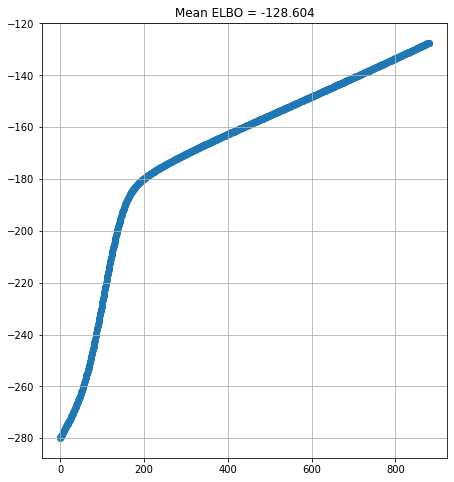

In [22]:
opt_state = optimizer.init(model_params)
params = model_params
loss_history = []

for epoch in range(num_epochs):
    loss, updates, opt_state = train_step_optax(epoch, params, opt_state, data)
    params = optax.apply_updates(params, updates)
    loss_history.append(loss)

    if epoch % 20 == 0:
        clear_output(True)
        plt.figure(figsize=[16, 8])
        plt.subplot(1, 2, 1)
        plt.title("Mean ELBO = %.3f" % -jnp.mean(jnp.array(loss_history[-32:])))
        plt.scatter(jnp.arange(len(loss_history)), jnp.array(loss_history)*-1.0)
        plt.grid()
        plt.show()

## Test policy

In [27]:
from tensorflow_probability.substrates import jax as tfp
tfb = tfp.bijectors

In [33]:
# inverse link function
#TODO: cast with default_float
invlink = tfb.Chain(bijectors=[
    tfb.Scale(scale=20-1e-5),
    tfb.Shift(shift=-0.5),
    tfb.NormalCDF()]
)

policy_model_spec = GPModelSpec(
    type=SVGP,
    num_inducing=32,
    likelihood=Gaussian(),
    prior=None,
    mean_function="default",
    model_uncertainty=False,
    invlink = invlink
)

policy = GPPolicy(
    action_space = jnp.array([0,1,2]),
    gp_model_spec=policy_model_spec,
    objective=objective,
    optimizer=policy_optimizer,
    inference_strategy=inference_strategy
)

NameError: name 'objective' is not defined

In [ ]:
environment_model = EnvironmentModel(
    transition_model=transition_model,
    reward_model=reward_model,
    initial_state_model=initial_state_model
)

virtual_driver = Driver(
    mode="plan",
    env=environment_model,
    policy=policy,
    transition_observers=[virtual_replay_buffer.push],
    observers=[],
    max_steps=30
)

In [ ]:
policy.initialize(experience)
virtual_driver.run(environment_model.reset())
virtual_experience = virtual_replay_buffer.get_last_n(virtual_driver.max_steps)
result = policy.train(virtual_experience)